# Blunder buster
Attemp at trying to identify recurring blunders/mistakes/misses in my chess games.
I am a degen chess player that almost always plays the same opening (some weird english variation).
And I am unwilling to learn the theory, and strictly learn trought many trial and error reps (bullet/blitz/rapid). 
Thus the assumption is that there should be many mistakes done over and over (without me ever noticing them) in roughly simillar positions. Let's try to identify them...

## Content
* Downloading games from chess.com
* Evaluating each move of each game and identifying blunders
* Clustering blunder positions based on hamming distance similarity
* Evaluating results

## Libraries
* `stockfish` - for evaluation (C stockfish needs to be installed on the system, the lib is just a python port). Docs: https://github.com/zhelyabuzhsky/stockfish
* `lc0` - An alternative engine (to stockfish) for evaluation. Lc0 is NN based engine that runs on GPU, thus on my desktop PC runs a bit faster then CPU brute-force based stockfish. Lc0 needs to be first compiled and available in PATH. Then python bindings can be install into an venv by running `pip install  git+https://github.com/LeelaChessZero/lc0.git`. Docs: 
* `chessdotcom` - is a convenient chess.com API wrapper lib. Docs: https://chesscom.readthedocs.io/en/latest/index.html
* `chess` - great library that can work with all standard chess notation formats (pgn, fen) and also allows to quickly visualize chess boards in Jupyter. Docs: https://python-chess.readthedocs.io/en/latest/#


In [1]:
from io import StringIO
from typing import List, Dict, Any
from chessdotcom import ChessDotComClient
from stockfish import Stockfish
from chess import pgn, Board, svg
import json
import numpy as np
import sklearn as sk
import pandas as pd

Let's implement some simple cache for storing stockfish evaluations on disk (as it is CPU costly as fuck).

In [2]:
_CACHE = {}
def load_cache():
    global _CACHE
    with open('blunder.cache', 'r') as f:
        _CACHE = json.load(f)
def store_cache():
    with open('blunder.cache', 'w+') as f:
        json.dump(_CACHE, f)

## Download games from chess.com 

In [3]:
_CHESSCOM = ChessDotComClient(user_agent = "My Python Application...")
def get_games(username: str, year: int, month: int) -> List[dict]:
    response = _CHESSCOM.get_player_games_by_month(username, year, month)
    json_response = response.json
    return json_response['games']

games = get_games('bowmann', 2024, 9)
games[0]

{'url': 'https://www.chess.com/game/live/118932035867',
 'pgn': '[Event "Live Chess"]\n[Site "Chess.com"]\n[Date "2024.09.01"]\n[Round "-"]\n[White "bowmann"]\n[Black "deepblue26"]\n[Result "0-1"]\n[CurrentPosition "5k2/7p/1pB2P2/1Pr3P1/3K3P/8/p7/8 w - -"]\n[Timezone "UTC"]\n[ECO "A20"]\n[ECOUrl "https://www.chess.com/openings/English-Opening-Kings-English-Variation...3.Bg2-d5-4.cxd5-Nxd5"]\n[UTCDate "2024.09.01"]\n[UTCTime "12:19:51"]\n[WhiteElo "1779"]\n[BlackElo "1799"]\n[TimeControl "600"]\n[Termination "deepblue26 won by resignation"]\n[StartTime "12:19:51"]\n[EndDate "2024.09.01"]\n[EndTime "12:33:13"]\n[Link "https://www.chess.com/game/live/118932035867"]\n\n1. g3 {[%clk 0:09:58.1]} 1... d5 {[%clk 0:09:58.3]} 2. Bg2 {[%clk 0:09:52.2]} 2... Nf6 {[%clk 0:09:54.3]} 3. c4 {[%clk 0:09:46.4]} 3... e5 {[%clk 0:09:47.2]} 4. cxd5 {[%clk 0:09:44.7]} 4... Nxd5 {[%clk 0:09:45.5]} 5. d3 {[%clk 0:09:43.7]} 5... Bb4+ {[%clk 0:09:25.9]} 6. Bd2 {[%clk 0:09:42.1]} 6... Bxd2+ {[%clk 0:09:18.2]} 7.

# Analyze games
* `pgn` data can be read by `chess` library, and then we can iterate over all moves and feed positions (in `fen` format) to Stockfish for evaluation.
* We will only record moves with significant (_BLUNDER_THRASHOLD) evaluation drop 
* for each such blunder move we will record a best move suggested by stockfish
* In the end we load this all to a pandas Dataframe (color - W/B, result - W/L/D, time_control is in seconds):

| game_uuid | color | fen_position | move | best_move | eval_drop | time_control | result|
|-----------|-------|--------------|------|-----------|-----------|--------------|-------|
|'2c0b08a8-6ec5-11e2-8002-000000000000'| W | 'r4r1k/p6p/1p1p2p1/2q1p3/8/1Q5P/PPP3P1/R4R1K w - - 0 23'| 'f1f8' | 'b3e6' | 0.7 | 600 | L|

## TODO

* Empirically find out what is the best _BLUNDER_THRASHOLD value
* Empirically find out what are the best stockfish params
* Consider Lc0 engine instead of Stockfish - running stockfish on my current CPU (6cores/12threads) doesn't seem to be the best option

In [10]:
_BLUNDER_THRASHOLD = 0.5
_STOCKFISH_PARAMS = {
    "Threads": 10,
    "Skill Level": 20,
    "Hash": 2048,
}
_STOCKFISH_DEPTH = 22

In [11]:
def analyze_game_stockfish(game_pgn: str, focus: int) -> List[dict]:
    """Analyze game by iterating over all game moves and evaluating each position.
    Focus only on moves of the particular player specified by `focus` param (0 for white 
    and 1 for black).
    """
    _pgn = StringIO(game_pgn)
    game = pgn.read_game(_pgn)
    board = game.board()
    stockfish = Stockfish(depth=_STOCKFISH_DEPTH, parameters=_STOCKFISH_PARAMS)
    stockfish.set_fen_position(board.fen())
    blunders = []
    evaluation = 0
    eval_before = 0
    best_move = None
    # 0 -white, 1-black
    # according to the latest and greatest chess rules, white always starts.
    player = 0
    # Iterate over game moves
    for move in game.mainline_moves():
        # Print some progress (Remove this once rewriting this into an app)
        print('.', end='')
        
        player = (player + 1) % 2
        pos_before = board.fen()
        eval_before = evaluation
        best_move_before = best_move
        
        # Play the move
        board.push(move)
        
        # Send the position to stockfish and evaluate
        stockfish.set_fen_position(board.fen())
        eval_before, evaluation = evaluation, stockfish.get_evaluation()['value'] / 100
        best_move = stockfish.get_best_move()

        # Do not record moves of the other player
        if not focus == player:
            continue
            
        eval_diff = eval_before - evaluation
        if eval_diff > _BLUNDER_THRASHOLD:
            blunders.append({
                'move': str(move),
                'best_move': str(best_move_before),
                'position': pos_before,
                'eval_drop': eval_diff,
                'color': ['w', 'b'][player],
            })
            
    return blunders

def analyze(username: str, year: int, month: int):
    """ Analyze all games for the specifier chess.com `username` in the
    given `year` and `month` time period.
    """
    games = get_games(username, year, month)
    analyzed_games = {}
    results = []
    for game in games:
        print("analyzing game:", game['uuid'])
        #if game['uuid'] in _CACHE:
        #    continue
        focus_player = int(username != game['white']['username'])
        b = analyze_game_stockfish(game['pgn'], focus_player)
        print()
        print(f"found {len(b)} blunders")
        analyzed_games[game['uuid']] = {'blunders': b, 'mistakes': m}
    return result

In [12]:
analyze_game_stockfish(games[0]['pgn'], 0)

............................................................................................

[]

In [13]:
analyze_game(games[0]['pgn'], 0)

............................................................................................

[]

In [ ]:
def get_blunder_positions(games):
    positions = [b['position'] for game in games['games'].values() for b in game['blunders']]
    moves = [b['move'] for game in games['games'].values() for b in game['blunders']]
    best_moves = [b['best_move'] for game in games['games'].values() for b in game['blunders']]
    # split fen position and fen metadata
    _positions = [p.split()[:2] for p in positions]
    positions_b = []
    positions_w = []
    moves_b = []
    moves_w = []
    best_moves_b = []
    best_moves_w = []
    for i,p in enumerate(_positions):
        if p[1] == 'b':
            positions_b.append(positions[i])
            moves_b.append(moves[i])
            best_moves_b.append(best_moves[i])
        else:
            positions_w.append(positions[i])
            moves_w.append(moves[i])
            best_moves_w.append(best_moves[i])
    return positions_b, positions_w, moves_b, moves_w, best_moves_b, best_moves_w

In [214]:
games = analyze('bowmann', 2024, 9)

analyzing game: 7d22d7d7-685c-11ef-a6d9-6cfe544c0428
............................................................................................found 0 blunder and 1 mistakes.
analyzing game: 61121543-6872-11ef-a6d9-6cfe544c0428
......................................................................................................found 1 blunder and 1 mistakes.
analyzing game: 5eb322bf-6a0a-11ef-a6d9-6cfe544c0428
.........................................................................................................................found 3 blunder and 1 mistakes.
analyzing game: 75c62d28-6a29-11ef-a6d9-6cfe544c0428
........................................................found 5 blunder and 7 mistakes.
analyzing game: 0a3e3270-6a2f-11ef-a6d9-6cfe544c0428
...........................................................................................found 10 blunder and 8 mistakes.
analyzing game: 5cf0ee22-6a3c-11ef-a6d9-6cfe544c0428
...........................................................

In [176]:
ga = []
for k,v in games['games'].items():
    ga.append({'uuid': k, **v})
b_pd = pd.json_normalize(ga, 'blunders')
b_pd

,move,best_move,position
0,d4e4,f3e2,8/8/p7/2p1p2p/P2kP2P/8/1P2KP2/8 b - - 1 38
1,f6e5,f5f6,8/2b5/5p1k/3PPK1p/5P1P/3B4/1p6/8 b - - 0 47
2,d8h4,f5e6,3b4/8/4P2k/3P1K1p/7P/3B4/1p6/8 b - - 0 49
3,h6g7,f5e5,8/8/3PP2k/5K1p/7b/3B4/1p6/8 b - - 0 50
4,c4d5,e6d5,rnbq1rk1/pp3pbp/3p1np1/2pp2B1/2P1P2P/2N5/PP2BP...
...,...,...,...
160,f2e3,a8h8,7r/p5k1/1p2p3/2pb2P1/5b2/2PB4/PP2KB2/6R1 w - -...
161,f1e1,f6e4,r2qr1k1/pp1n1pbp/3p1np1/2pP4/2P3b1/2N2N2/PP1BB...
162,e2e3,d8d7,r5k1/pp3pbp/3p1qp1/2pPn3/2P1Q3/5P2/PP1BRP1P/R5...
163,e3e2,h6f4,r5k1/pp3p1p/3p1qp1/2pPn3/2P1Qb2/4R3/PP1B1P1P/R...


In [14]:
load_cache()

In [215]:
b,w,m_b,m_w,b_m_b,b_m_w = get_blunder_positions(games)

In [1]:
b_m_w[:5]

NameError: name 'b_m_w' is not defined

## Fen position normalization
To be able to use hamming distance for computing distance matrix we need to normalize the positions to the same lenght:
* First we remove fen notation "metadata"
* and then we expand numbers to "dashes" (2p5 to --p-----)

this will yield position strings of 8*8 length (plus 7 separating backslashes)

In [67]:
def normalize(position: str) -> str:
    # Strip fen metadata 
    # i.e. this:
    # "rnbqkbnr/pp1ppppp/8/2p5/4P3/8/PPPP1PPP/RNBQKBNR w KQkq c6 0 2"
    # to this:
    # "rnbqkbnr/pp1ppppp/8/2p5/4P3/8/PPPP1PPP/RNBQKBNR"
    position = position.split()[0]

    # Now mormalize to the same lenght by expanding num values like this
    # 2p5 to --p-----
    normalized = ''
    #TODO: This is more of an idea: also uppercase and in rotate for on color 
    for x in position:
        if x in '12345678':
            normalized += int(x)*'-'
        else:
            normalized += x
    return normalized

In [217]:
norm_b = list(map(normalize, b))
norm_w = list(map(normalize, w))

In [218]:
norm_b

['--------/--------/p------p/--p-p---/P--kP--P/-----K--/-P---P--/--------',
 '--------/--b-----/-----p-k/---PPK-p/-----P-P/---B----/-p------/--------',
 '--------/--b-----/-------k/---PPK-p/-------P/---B----/-p------/--------',
 '--------/--------/---PP--k/-----K-p/-------b/---B----/-p------/--------',
 '--------/-------p/--------/-R-n----/-p--nk--/-------P/--------/------K-',
 '-----k--/--------/------p-/--------/--------/--nB---P/-p-K-P--/--------',
 '-----k--/--------/------p-/--------/--------/--n----P/---K-P--/-B------',
 '----r-k-/-p---pp-/pq---n-p/--------/-----B--/-PQ--PP-/P-----KP/--R-----',
 '--Qb--k-/---N--p-/p------p/-----p-r/---p-P--/PP-P--Pq/---BP-RP/------K-',
 '---Q--k-/---N--p-/p------p/-----p-r/---p-Pq-/PP-P--P-/---BP-RP/------K-',
 '---Q-N--/------pk/p------p/-----p-r/---p-Pq-/PP-P--P-/---BP-RP/------K-',
 '--------/-----k--/-------R/-----K-p/---B-P--/---P--P-/-------P/----r---',
 '--------/-----k--/--------/---rBK-R/-----P-P/------P-/--------/--------',
 '--------/-

In [219]:
# Lets calculate distance matrix firs
from scipy.spatial.distance import hamming
pos_n = len(norm_w)
distance_matrix = np.zeros((pos_n, pos_n))
for i, i_pos in enumerate(norm_w):
    for j, j_pos in enumerate(norm_w):
        distance_matrix[i][j] = hamming(list(i_pos), list(j_pos))
distance_matrix
        

array([[0.        , 0.14084507, 0.18309859, ..., 0.29577465, 0.29577465,
        0.26760563],
       [0.14084507, 0.        , 0.05633803, ..., 0.32394366, 0.32394366,
        0.26760563],
       [0.18309859, 0.05633803, 0.        , ..., 0.32394366, 0.32394366,
        0.26760563],
       ...,
       [0.29577465, 0.32394366, 0.32394366, ..., 0.        , 0.07042254,
        0.16901408],
       [0.29577465, 0.32394366, 0.32394366, ..., 0.07042254, 0.        ,
        0.15492958],
       [0.26760563, 0.26760563, 0.26760563, ..., 0.16901408, 0.15492958,
        0.        ]], shape=(144, 144))

## Clustering 

Now lets try to apply/find some suitable clustering algorithm and find out what happens :-).

In [220]:
# Now lets try to apply some clustering algo
from sklearn.cluster import DBSCAN
db = DBSCAN(metric='precomputed', eps=0.2)
clusters = db.fit_predict(distance_matrix)

In [221]:
clusters

array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
       -1, -1,  2,  2,  2,  2,  3, -1, -1, -1, -1, -1, -1,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3, -1, -1,  3,  4,
        4,  4,  4,  4,  4,  3,  3, -1,  2,  2,  2,  2,  2,  3, -1, -1, -1,
       -1,  2,  2,  2, -1, -1, -1, -1, -1, -1, -1, -1, -1,  2,  2,  2,  2,
        2,  3,  3, -1, -1, -1,  2,  2,  2,  3, -1, -1, -1, -1, -1, -1,  2,
       -1, -1,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6, -1, -1,  7,
        7,  7,  7,  7,  7, -1, -1,  7, -1, -1, -1, -1, -1, -1,  3,  8,  8,
        8,  8,  8, -1, -1, -1, -1, -1])

In [222]:
groups = {}
for i, i_g in enumerate(clusters):
    if i_g not in groups:
        groups[int(i_g)] = []
    groups[int(i_g)].append((w[i], m_w[i], b_m_w[i]))

In [223]:
groups[7]

[('r4r1k/p6p/1p1p2p1/2q1p3/8/1Q5P/PPP3P1/R4R1K w - - 0 23', 'f1f8', 'b3e6'),
 ('5r1k/2q4p/1p1pQ1p1/p3p3/8/2P4P/PP4P1/R6K w - - 2 26', 'h1g1', 'a1d1'),
 ('8/3q2kp/3p1rp1/1p1Qp3/p7/2P4P/PP4P1/3R2K1 w - - 10 37', 'd5e4', 'd5e5'),
 ('8/3q2kp/3p1rp1/1p2p3/p3Q3/2P4P/PP4P1/3R3K w - - 14 39', 'd1d5', 'c3c4'),
 ('8/5qkp/3p1rp1/1p1Rp3/p3Q3/2P4P/PP4P1/7K w - - 16 40', 'e4d3', 'd5b5'),
 ('8/5qkp/3p2p1/1p1Rp3/p7/2PQ3P/PP4P1/5r1K w - - 18 41', 'h1h2', 'h1h2'),
 ('8/3q1pk1/3p1ppp/pp1Pr3/7Q/P1P4P/1P3PP1/3R2K1 w - - 0 27', 'f2f4', 'c3c4')]

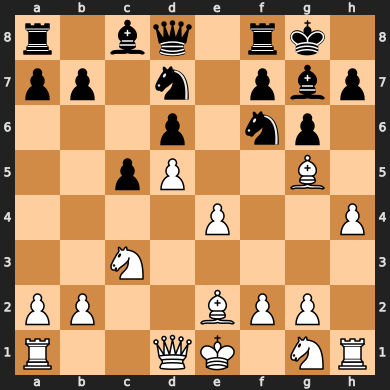

In [119]:
Board(groups[0][0][0])

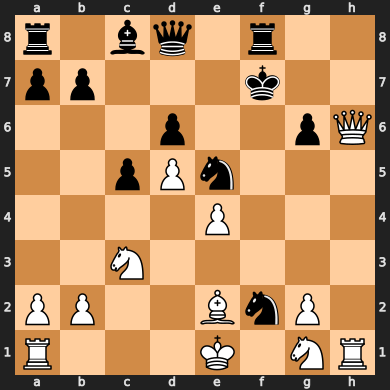

In [120]:
Board(groups[0][2][0])

In [255]:
def draw(g: int, p: int):
    b = Board(groups[g][p][0])
    m = groups[g][p][1]
    b_m = groups[g][p][2]
    arrow_move = svg.Arrow.from_pgn(f"R{m}")
    arrow_best_move = svg.Arrow.from_pgn(f"G{b_m}")
    return svg.board(b, arrows=[arrow_move, arrow_best_move], size=500)
    

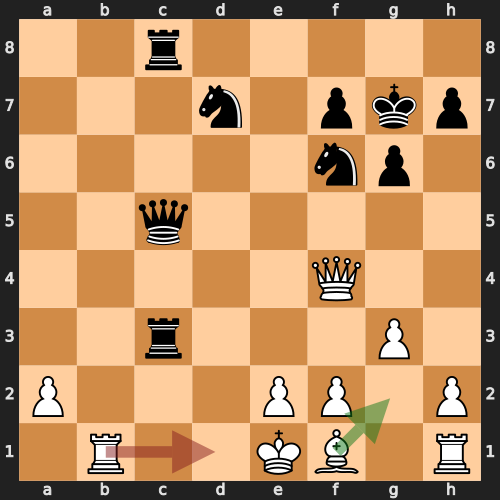

In [262]:
draw(3,9)